In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist
from keras.models import Model 
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose


In [5]:
#Define the following variables

(x_train, _), (x_test, _) = fashion_mnist.load_data()

X_train = x_train.astype('float32') / 255.
X_test = x_test.astype('float32') / 255.
	
input_dim = (28,28,1)
latent_dim = (7,7,1)
output_dim = (28,28,1)

In [6]:
x = Input(shape=(28,28,1))
x1 = Conv2D(32, 3, activation="relu", strides=2, padding="same")(x) # imagen de 14x14
h = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x1) # 7x7
r1 = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(h) # imagen de 14x14
r = Conv2DTranspose(1, 3, activation="sigmoid",strides=2, padding="same")(r1) # 28 x 28


In [7]:
# Loss Functions

# MSE
from keras.losses import MeanSquaredError
mse_loss = MeanSquaredError()

# Structural Similarity Index (SSIM)
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=255))


# Define the corruption process
	
def corruption_process(X):
    epsilon = np.zeros_like(X)
    epsilon += np.random.normal(0,0.1,size=X.shape)
    X_tilde = X +  epsilon 
    X_tilde = np.clip(X_tilde,0.,1.)

    return X_tilde





In [9]:
# Encoder and decoder
encoder = Model(inputs=x, outputs=h)
decoder = Model(inputs=h, outputs=r)


In [11]:
class autoencoder(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        z = self.encoder(x)
        r = self.decoder(z)
        return r

AutoEncoder = autoencoder(encoder, decoder)
AutoEncoder.compile(optimizer='adam', loss=ssim_loss)

AutoEncoder.summary()

Model: "autoencoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_2 (Functional)       │ (None, 7, 7, 64)       │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 28, 28, 1)      │        18,753 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,569 (146.75 KB)

 Trainable params: 37,569 (146.75 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
epochs = 5
batch_size = 128
X_train_corrupted = corruption_process(X_train)
X_test_corrupted = corruption_process(X_test)
history = AutoEncoder.fit(X_train_corrupted, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_corrupted,X_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 1.0454e-04 - val_loss: 9.9241e-05
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 9.8471e-05 - val_loss: 9.5088e-05
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 9.3919e-05 - val_loss: 9.2120e-05
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 9.1013e-05 - val_loss: 9.5761e-05
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 8.8304e-05 - val_loss: 8.6482e-05


In [14]:
denoised_imgs = AutoEncoder.predict(X_test_corrupted)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


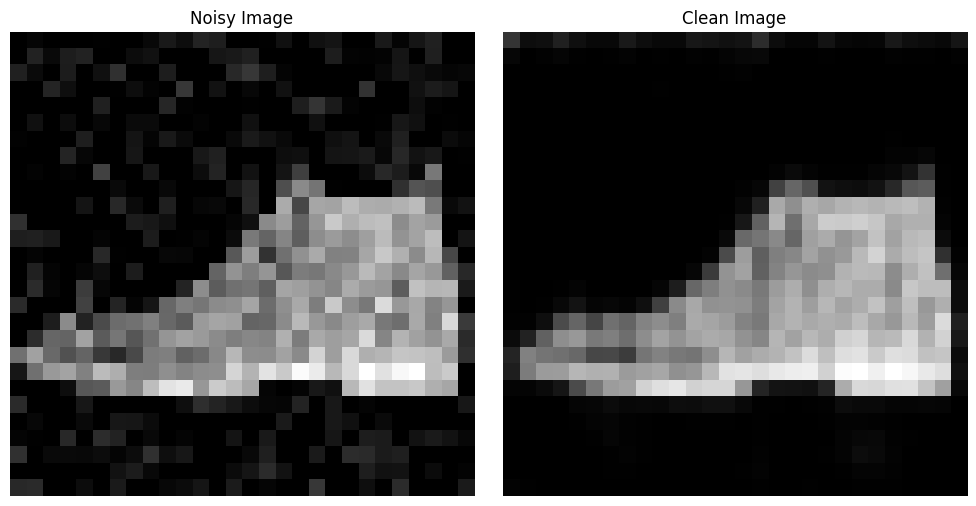

In [17]:
# Show a sample of the recontructed images

m = np.random.randint(0, len(X_test)-1)

image1 = X_test_corrupted[0]
#latent_image = latent_imgs[0]
image2 = denoised_imgs[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # 1 row, 2 columns, adjust figsize as needed

# Display Image 1 in the first subplot
axes[0].imshow(image1, cmap='gray') # Use a colormap suitable for your image type
axes[0].set_title('Noisy Image')
axes[0].axis('off') # Turn off axis labels and ticks for cleaner display

# Display Image 2 in the first subplot
axes[1].imshow(image2, cmap='gray') # Use a colormap suitable for your image type
axes[1].set_title('Clean Image')
axes[1].axis('off') # Turn off axis labels and ticks for cleaner display

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

In [53]:
from PIL import Image

img = Image.open('pengbrew.png')
new_size = (28,28)
img2 = img.resize(new_size)
np_img = np.asarray(img2) / 255.
noisy_img = np.reshape(corruption_process(np_img), (28,28,1))

denoised_img2 = np.reshape(AutoEncoder.predict(noisy_img), (28,28,4))
denoised_img2 = tf.reduce_mean(denoised_img2, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


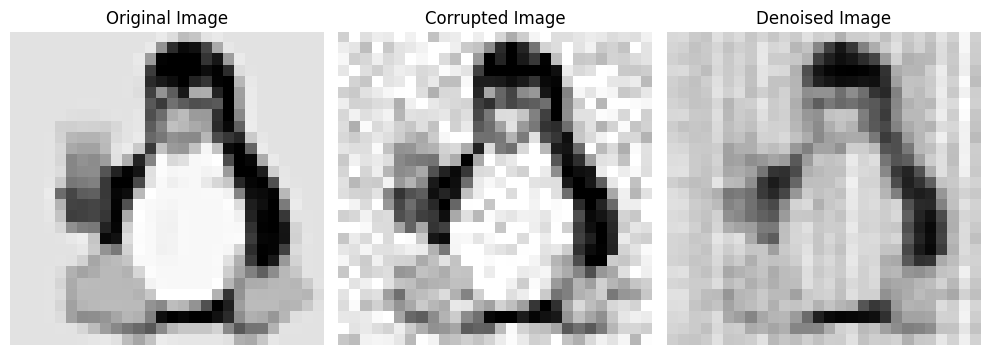

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5)) # 1 row, 2 columns, adjust figsize as needed

# Display Image 1 in the first subplot
axes[0].imshow(np_img, cmap='gray') # Use a colormap suitable for your image type
axes[0].set_title('Original Image')
axes[0].axis('off') # Turn off axis labels and ticks for cleaner display

# Display Image 2 in the first subplot
axes[1].imshow(noisy_img, cmap='gray') # Use a colormap suitable for your image type
axes[1].set_title('Corrupted Image')
axes[1].axis('off') # Turn off axis labels and ticks for cleaner display

# Display Image 2 in the first subplot
axes[2].imshow(denoised_img2, cmap='gray') # Use a colormap suitable for your image type
axes[2].set_title('Denoised Image')
axes[2].axis('off') # Turn off axis labels and ticks for cleaner display


plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()